In [1]:
import numpy as np
from collections import defaultdict
from gym import spaces

import ipywidgets
from ipywidgets import interact
from IPython.display import Image
import IPython

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import Categorical

from matplotlib import rcParams
rcParams['font.size'] = 24
rcParams['figure.figsize'] = (20, 8)

from rllib.environment.mdps import EasyGridWorld
from rllib.value_function import TabularQFunction, TabularValueFunction
from rllib.util.neural_networks.utilities import one_hot_encode
from rllib.policy import TabularPolicy


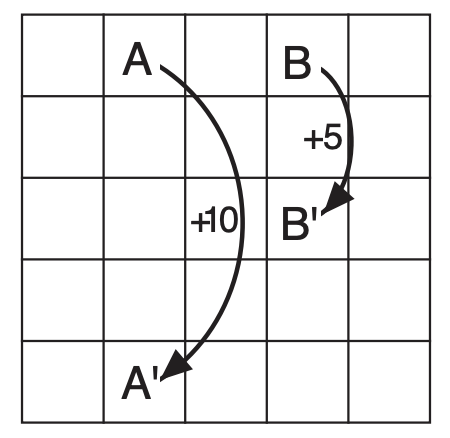

In [2]:
def extract_policy(q_function):
    """Extract a policy from the q_function."""
    policy = TabularPolicy(num_states=q_function.num_states,
                           num_actions=q_function.num_actions)
    for state in range(policy.num_states):
        q_val = q_function(torch.tensor(state).long())
        action = torch.argmax(q_val)

        policy.set_value(state, action)

    return policy


def integrate_q(q_function, policy):
    value_function = TabularValueFunction(num_states=q_function.num_states)
    for state in range(policy.num_states):
        state = torch.tensor(state).long()
        pi = Categorical(logits=policy(state))
        value = 0
        for action in range(policy.num_actions):
            value += pi.probs[action] * \
                q_function(state, torch.tensor(action).long())

        value_function.set_value(state, value)

    return value_function

# Plotters
def policy2str(policy):
    left = u'\u2190'
    right = u'\u2192'
    up = u'\u2191'
    down = u'\u2193'
    policy_str = ""
    if 0 == policy:
        policy_str += down 
    if 1 == policy:
        policy_str += up 
    if 2 == policy:
        policy_str += right
    if 3 == policy:
        policy_str += left
    return policy_str

def plot_value_function(value_function, ax):
    ax.imshow(value_function, vmin=-1, vmax=30)
    rows, cols = value_function.shape
    for row in range(rows):
        for col in range(cols):
            ax.text(row, col, f"{value_function[col, row]:.1f}", ha="center", va="center", color="w", fontsize=24)

def plot_policy(policy, ax):
    rows, cols = policy.shape
    ax.imshow(np.zeros((rows, cols)))
    for row in range(environment.height):
        for col in range(environment.width):
            ax.text(col, row, policy2str(policy[row, col]), ha="center", va="center", color="r", fontsize=24)


def plot_value_and_policy(value_function, policy):
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

    plot_value_function(value_function, axes[0])
    plot_policy(policy, axes[1])
    
environment = EasyGridWorld()
Image("images/grid_world.png")

### Grid world Example 
#### Some explanation
Same grid world example as grid world planning
In this Markov Decision Processes example, the states set: grid posions the agent stays(5x5).
The actions include: moving up, down, left, and right. 
With the noise probability, the agent will do nothing but stay put.
Note that this is a spare reward MDPs. The agent will get a reward of +10 if it enters grid A and moves to A' regardless of the action. Similarly, the agent will get a +5 reward if it enters grid B.
If the agent bump against the wall, it will get a -1 reward.

For more details and derivation of MDPs you can check the [work](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf) of Sutton and Barto. Page 72, Example 3.8: Gridworld.


# Exact Planning 

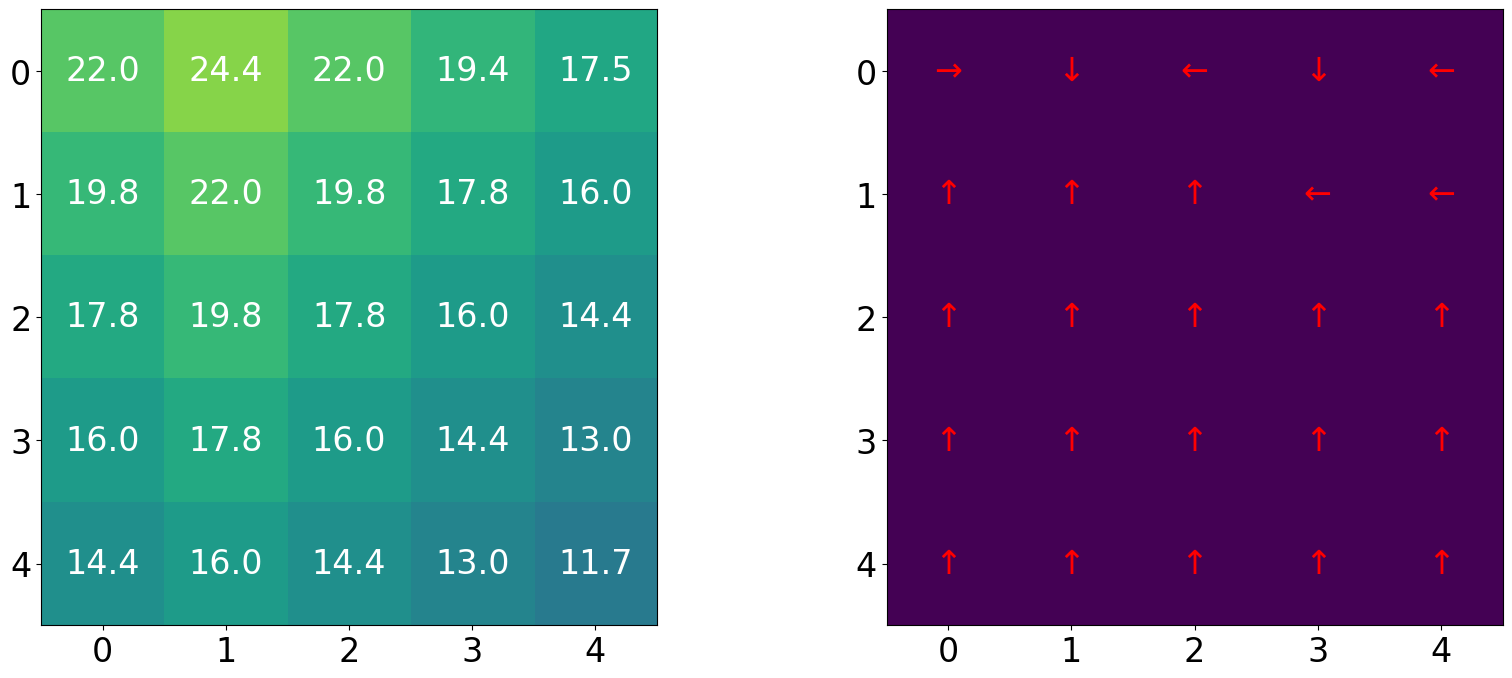

In [3]:
# Planning
def init_value_function(num_states, terminal_states=None):
    """Initialize value function."""
    value_function = TabularValueFunction(num_states=num_states)
    terminal_states = [] if terminal_states is None else terminal_states
    for terminal_state in terminal_states:
        value_function.set_value(terminal_state, 0)

    return value_function


def build_mrp_matrices(environment, policy):
    mrp_kernel = np.zeros((environment.num_states, 1, environment.num_states))
    mrp_reward = np.zeros((environment.num_states, 1))

    for state in range(environment.num_states):
        state = torch.tensor(state).long()
        policy_ = Categorical(logits=policy(state))

        for a, p_action in enumerate(policy_.probs):
            for transition in environment.transitions[(state.item(), a)]:
                with torch.no_grad():
                    p_ns = transition["probability"]
                    mrp_reward[state, 0] += p_action * p_ns * transition["reward"]
                    mrp_kernel[state, 0, transition["next_state"]
                               ] += p_action * p_ns

    return mrp_kernel, mrp_reward


def kernelreward2transitions(kernel, reward):
    """Transform a kernel and reward matrix into a transition dicitionary."""
    transitions = defaultdict(list)

    num_states, num_actions = reward.shape

    for state in range(num_states):
        for action in range(num_actions):
            for next_state in np.where(kernel[state, action])[0]:
                transitions[(state, action)].append(
                    {
                        "next_state": next_state,
                        "probability": kernel[state, action, next_state],
                        "reward": reward[state, action],
                    }
                )

    return transitions


def linear_system_policy_evaluation(environment, policy, gamma, value_function=None):
    """Evaluate a policy in an MDP solving the system bellman of equations.

    V = r + gamma * P * V
    V = (I - gamma * P)^-1 r
    """

    if value_function is None:
        value_function = init_value_function(environment.num_states)

    kernel, reward = build_mrp_matrices(environment=environment, policy=policy)

    A = torch.eye(environment.num_states) - gamma * kernel[:, 0, :]
    # torch.testing.assert_allclose(A.inverse() @ A, torch.eye(model.num_states))
    vals = A.inverse() @ reward[:, 0]
    for state in range(environment.num_states):
        value_function.set_value(state, vals[state].item())

    return value_function


def policy_iteration(environment, gamma):
    """Implement Policy Iteration algorithm.

    Parameters
    ----------
    gamma: float.
        discount factor.

    References
    ----------
    Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction.
    MIT press.
    Chapter 4.3

    """
    max_iter = 10
    value_function = init_value_function(environment.num_states)
    policy = TabularPolicy(num_states=environment.num_states,
                           num_actions=environment.num_actions)

    for num_iter in range(max_iter):
        # Evaluate the policy.
        value_function = linear_system_policy_evaluation(
            environment, policy, gamma)
        policy_stable = True
        for state in range(environment.num_states):

            value_ = torch.zeros(environment.num_actions)
            for action in range(environment.num_actions):
                value_estimate = 0
                for transition in environment.transitions[(state, action)]:
                    next_state = torch.tensor(transition["next_state"]).long()
                    reward = torch.tensor(transition["reward"]).double()
                    value_estimate += transition["probability"] * (
                        reward + gamma *
                        value_function(next_state).item()
                    )

                value_[action] = value_estimate

            state = torch.tensor(state).long()
            old_policy = policy(state)
            old_action = torch.argmax(old_policy)

            action = torch.argmax(value_)
            policy.set_value(state, action)

            policy_stable &= (action == old_action).all().item()

        if policy_stable:
            break

    return value_function, policy


value_function, policy = policy_iteration(environment, 0.9)

plot_value_and_policy(value_function.table.reshape(5, 5).detach().numpy(),
                      policy.table.argmax(0).reshape(5, 5).detach().numpy())

### Some explanation 
Exact planning means we have already known the MDPs: the transition model.
Based on this we could use policy iteration / value iteration to calculate the optimal policy as well as the value function
In the above left image shows the value function and right is the optimal policy. You could use this as comparison for following method.

# Model Based: Estimate a model, plan with such a model. 

In [4]:
class Model(object):
    def __init__(self, num_states, num_actions, rmax):
        self.num_states = num_states + 1
        self.num_actions = num_actions 
        
        self.probs = np.zeros((num_states + 1, num_actions, num_states + 1))
        self.probs[:, :, -1] = 1
        self.counts = np.zeros((num_states + 1, num_actions, num_states + 1))
            
        self.rewards = rmax * np.ones((num_states + 1, num_actions))         
        self.transitions = kernelreward2transitions(self.probs, self.rewards)
    
    def update_model(self): 
        for state in range(self.num_states):
            for action in range(self.num_actions):
                n_sa = self.counts[state, action].sum()
                if n_sa == 0:  # If state action pair was not visited, then do not update the model.
                    continue
                for next_state in range(self.num_states):
                    self.probs[state, action, next_state] = self.counts[state, action, next_state] / n_sa
        self.transitions = kernelreward2transitions(self.probs, self.rewards)
        
class EpsGreedyPolicy(object):
    def __init__(self, policy, epsilon):
        self.policy = policy
        self.epsilon = epsilon 
    
    def __call__(self, state):
        if not isinstance(state, torch.Tensor):
            torch.tensor(state).long()
        dist = Categorical(logits=self.policy(state))
        probs = dist.probs
        mixture = probs * (1 - self.epsilon) + self.epsilon / self.policy.num_actions
        return Categorical(probs=mixture).logits

In [11]:
def rmax(gamma, noise, rmax_exploration, epsilon):
    output = ipywidgets.Output()
    global model, policy, value_function
    environment = EasyGridWorld(noise=noise)
    episode_horizon=20
    if rmax_exploration:
        rmax = 10
    else:
        rmax=0
    model = Model(environment.num_states, environment.num_actions, rmax=rmax)
    value_function, policy = policy_iteration(model, gamma=0.9)
    
    def step(num_episodes):
        global model, policy, value_function
        for i_episode in range(num_episodes):
            state = environment.reset()  # The initial distribution plays a big role. 
            environment.state = 2
            state = 2
            for i in range(episode_horizon):
                if np.random.rand() < epsilon:
                    action = np.random.randint(policy.num_actions)
                else:
                    action = torch.argmax(policy(torch.tensor(state).long())).item()  # Rollout Policy                  
                
                next_state, reward, done, info = environment.step(action)
                model.counts[state, action, next_state] += 1  # update count
                model.rewards[state, action] = reward  # update model.

                state = next_state 

            model.update_model()
            value_function, policy = policy_iteration(model, gamma=0.9)
            
        plot()
    
    def plot():
        with output:
            output.clear_output()
            exploration_vf = linear_system_policy_evaluation(environment, EpsGreedyPolicy(policy, epsilon), gamma)
            testing_vf = linear_system_policy_evaluation(environment, policy, gamma)
            plot_all(
                value_function.table[:, :-1].reshape(5, 5).detach().numpy(), 
                policy.table.argmax(0)[:-1].reshape(5, 5).detach().numpy(),
                exploration_vf.table.reshape(5, 5).detach().numpy(),
                testing_vf.table.reshape(5, 5).detach().numpy(),
            )

            plt.show()

        
    plot()
    button = ipywidgets.Button(description="Step 1 Episode")
    button.on_click(lambda b: step(num_episodes=1))
    button2 = ipywidgets.Button(description="Step 10 Episodes")
    button2.on_click(lambda b: step(num_episodes=10))
    display(button, button2, output)

    
def plot_all(estimated_value, policy, exploration_value_function, testing_value_function):
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 6))
    plot_value_function(estimated_value, axes[0])
    axes[0].set_title('Estimated Value')
    plot_policy(policy, axes[1])
    axes[1].set_title('Policy')
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 6))
    plot_value_function(exploration_value_function, axes[0])
    axes[0].set_title('Exploration Value')
    plot_value_function(testing_value_function, axes[1])
    axes[1].set_title('Testing Value')
        
interact(
    rmax,
    gamma=ipywidgets.FloatSlider(
        value=0.9, min=0., max=0.99, step=1e-2, continuous_update=False),
    noise=ipywidgets.FloatSlider(
        value=0, min=0., max=0.2, step=1e-2, continuous_update=False),
    epsilon=ipywidgets.FloatSlider(
            value=0.1, min=0., max=1.0, step=1e-2, continuous_update=False),
    rmax_exploration=False,
);

interactive(children=(FloatSlider(value=0.9, continuous_update=False, description='gamma', max=0.99, step=0.01…

## Demo Guide:

#### some explanation
This demo shows one of the basic reinforcment learning approach: Model-based method.
We will first learn the MDP by estimating the transition probabilities and the reward function.
Then we optimize the policy based on the estimated MDP.
- gamma: the discount factor of the environment.
- noise: when noise > 0, then transitions happen with probability = 1-noise.
- rmax_exploration: whether to use the R_max alogirthm which will set the initial reward to R_max
- epsilon: the parameter trading the exploration and exploitation. With epislon probability will pick random action and 1-epislon pick the best action.

- step 1 Episode: Interacting the environment 1 time, generate one state, action, reward pair which has the length of horizon 20. 
- step 10 Episode: Interacting the environment 10 times, Note that the MDPs is learned after each iteration.

- Estimated value: the estimated value function learned by interacting the world.
- Policy: the optimal policy based on the learned MDP
- Exploration value: given the policy we can evaluate the policy based on the epislon greedy algorithm by solving the Bellman equation by solving linear system. 
- Testing value: given the policy we can evaluate the policy by solving the Bellman equation by solving linear system.
- rewards \[state x actions \]: This prints information 25x4 lists shows the learned reward for 25 states (5x5) for 4 actions (down, up, right, left)


#### play around
- step 1 Episode with the default setting. Think about why the policy change while the estimated value did not change. Check the difference between the exploration value and testing value. Change the epislon and see the difference again
- Play around the parameters and see how to learn the MDPs in the fastest way. Compare the results with the one of exacting.
